# Robust Linear Models

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

## Estimation

Load data:

In [3]:
data = sm.datasets.stackloss.load()
data.exog = sm.add_constant(data.exog)

Huber's T norm with the (default) median absolute deviation scaling

In [4]:
huber_t = sm.RLM(data.endog, data.exog, M=sm.robust.norms.HuberT())
hub_results = huber_t.fit()
print(hub_results.params)
print(hub_results.bse)
print(
    hub_results.summary(
        yname="y", xname=["var_%d" % i for i in range(len(hub_results.params))]
    )
)

const       -41.026498
AIRFLOW       0.829384
WATERTEMP     0.926066
ACIDCONC     -0.127847
dtype: float64
const        9.791899
AIRFLOW      0.111005
WATERTEMP    0.302930
ACIDCONC     0.128650
dtype: float64
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                   21
Model:                            RLM   Df Residuals:                       17
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 28 Oct 2024                                         
Time:                        23:52:14                                         
No. Iterations:                    19                                         


Huber's T norm with 'H2' covariance matrix

In [5]:
hub_results2 = huber_t.fit(cov="H2")
print(hub_results2.params)
print(hub_results2.bse)

const       -41.026498
AIRFLOW       0.829384
WATERTEMP     0.926066
ACIDCONC     -0.127847
dtype: float64
const        9.089504
AIRFLOW      0.119460
WATERTEMP    0.322355
ACIDCONC     0.117963
dtype: float64


Andrew's Wave norm with Huber's Proposal 2 scaling and 'H3' covariance matrix

In [6]:
andrew_mod = sm.RLM(data.endog, data.exog, M=sm.robust.norms.AndrewWave())
andrew_results = andrew_mod.fit(scale_est=sm.robust.scale.HuberScale(), cov="H3")
print("Parameters: ", andrew_results.params)

Parameters:  const       -40.881796
AIRFLOW       0.792761
WATERTEMP     1.048576
ACIDCONC     -0.133609
dtype: float64


See ``help(sm.RLM.fit)`` for more options and ``module sm.robust.scale`` for scale options

## Comparing OLS and RLM

Artificial data with outliers:

In [7]:
nsample = 50
x1 = np.linspace(0, 20, nsample)
X = np.column_stack((x1, (x1 - 5) ** 2))
X = sm.add_constant(X)
sig = 0.3  # smaller error variance makes OLS<->RLM contrast bigger
beta = [5, 0.5, -0.0]
y_true2 = np.dot(X, beta)
y2 = y_true2 + sig * 1.0 * np.random.normal(size=nsample)
y2[[39, 41, 43, 45, 48]] -= 5  # add some outliers (10% of nsample)

### Example 1: quadratic function with linear truth

Note that the quadratic term in OLS regression will capture outlier effects. 

In [8]:
res = sm.OLS(y2, X).fit()
print(res.params)
print(res.bse)
print(res.predict())

[ 5.0579291   0.51300217 -0.01181437]
[0.44657301 0.06894485 0.00610055]
[ 4.7625698   5.01821212  5.26991796  5.51768732  5.76152019  6.00141658
  6.23737649  6.46939991  6.69748685  6.9216373   7.14185127  7.35812876
  7.57046976  7.77887428  7.98334231  8.18387386  8.38046893  8.57312751
  8.76184961  8.94663523  9.12748436  9.30439701  9.47737317  9.64641285
  9.81151605  9.97268276 10.12991299 10.28320674 10.432564   10.57798478
 10.71946907 10.85701688 10.99062821 11.12030305 11.24604141 11.36784329
 11.48570868 11.59963759 11.70963001 11.81568595 11.91780541 12.01598838
 12.11023487 12.20054487 12.28691839 12.36935543 12.44785598 12.52242005
 12.59304764 12.65973874]


Estimate RLM:

In [9]:
resrlm = sm.RLM(y2, X).fit()
print(resrlm.params)
print(resrlm.bse)

[ 4.98509214e+00  5.01123085e-01 -1.86336427e-03]
[0.12360008 0.01908218 0.00168848]


Draw a plot to compare OLS estimates to the robust estimates:

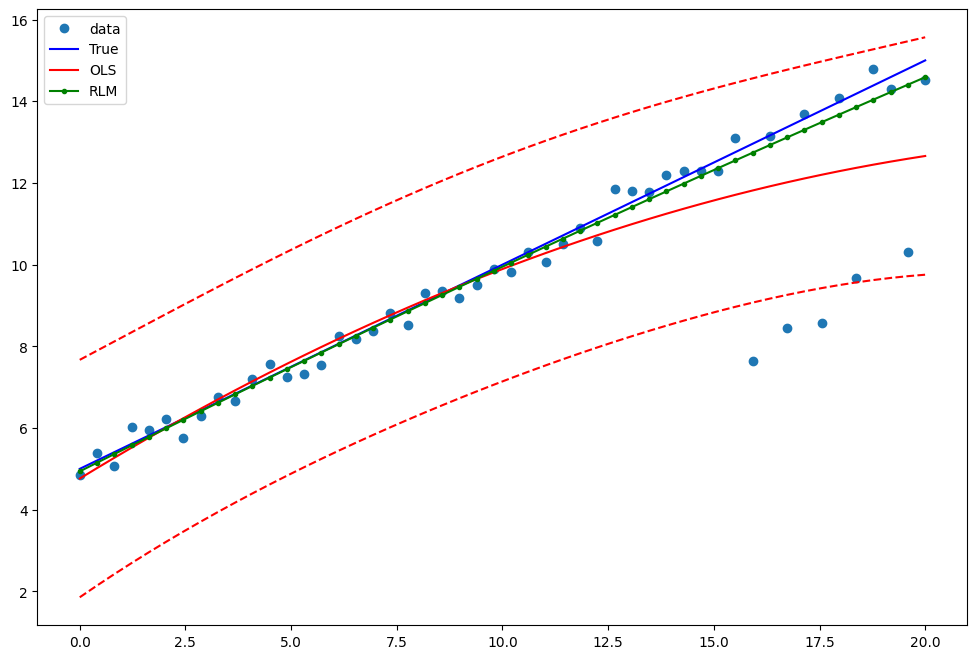

In [10]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(x1, y2, "o", label="data")
ax.plot(x1, y_true2, "b-", label="True")
pred_ols = res.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

ax.plot(x1, res.fittedvalues, "r-", label="OLS")
ax.plot(x1, iv_u, "r--")
ax.plot(x1, iv_l, "r--")
ax.plot(x1, resrlm.fittedvalues, "g.-", label="RLM")
ax.legend(loc="best")

### Example 2: linear function with linear truth

Fit a new OLS model using only the linear term and the constant:

In [11]:
X2 = X[:, [0, 1]]
res2 = sm.OLS(y2, X2).fit()
print(res2.params)
print(res2.bse)

[5.53412062 0.39485845]
[0.38331263 0.03302777]


Estimate RLM:

In [12]:
resrlm2 = sm.RLM(y2, X2).fit()
print(resrlm2.params)
print(resrlm2.bse)

[5.04694701 0.4848568 ]
[0.10131763 0.00872994]


Draw a plot to compare OLS estimates to the robust estimates:

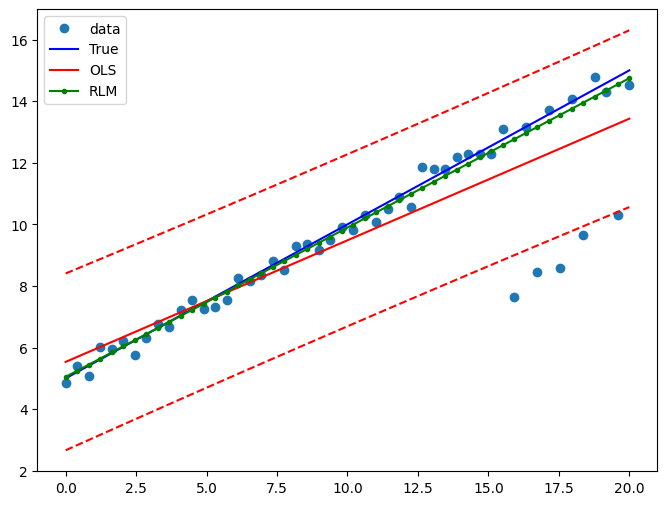

In [13]:
pred_ols = res2.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x1, y2, "o", label="data")
ax.plot(x1, y_true2, "b-", label="True")
ax.plot(x1, res2.fittedvalues, "r-", label="OLS")
ax.plot(x1, iv_u, "r--")
ax.plot(x1, iv_l, "r--")
ax.plot(x1, resrlm2.fittedvalues, "g.-", label="RLM")
legend = ax.legend(loc="best")